In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Resize CIFAR-10 images to fit InceptionV3 input size (75x75x3)
x_train = tf.image.resize(x_train, (75, 75))
x_test = tf.image.resize(x_test, (75, 75))

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
# Initialize InceptionV3 with pre-trained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model.trainable = False  # Freeze the base model

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# Early stopping callback to stop training if validation loss does not improve for 3 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=5,               # Stop after 3 epochs with no improvement
    restore_best_weights=True # Restore model weights from the epoch with the best validation loss
)

# Reduce learning rate callback if validation loss does not improve for 2 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Monitor validation loss
    factor=0.1,               # Reduce learning rate by a factor of 0.5
    patience=3,               # Trigger after 2 epochs with no improvement
    min_lr=1e-10              # Set a minimum learning rate to prevent it from going too low
)

In [5]:
# Train the model without data augmentation
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=20,
                    validation_data=(x_test, y_test),
                    validation_batch_size=1024,    # Set a custom validation batch size
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 74s 963ms/step - accuracy: 0.4028 - loss: 1.7709 - val_accuracy: 0.6134 - val_loss: 1.1219 - learning_rate: 0.0010
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 186ms/step - accuracy: 0.6462 - loss: 1.0189 - val_accuracy: 0.6391 - val_loss: 1.0354 - learning_rate: 0.0010
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 0.6904 - loss: 0.9008 - val_accuracy: 0.6510 - val_loss: 1.0036 - learning_rate: 0.0010
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.7175 - loss: 0.8229 - val_accuracy: 0.6555 - val_loss: 0.9894 - learning_rate: 0.0010
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.7377 - loss: 0.7681 - val_accuracy: 0.6608 - val_loss: 0.9901 - learning_rate: 0.0010
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.7623 - loss: 0.7003 - val_accuracy: 0.6580 - val_loss: 0.9884 - learning_rate: 0.0010
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.7840 - loss: 0.650

In [6]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.6557 - loss: 0.9905
Test accuracy: 65.80%


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.71      0.70      1000
  automobile       0.70      0.82      0.76      1000
        bird       0.58      0.55      0.57      1000
         cat       0.52      0.47      0.50      1000
        deer       0.58      0.59      0.59      1000
         dog       0.66      0.61      0.63      1000
        frog       0.64      0.69      0.67      1000
       horse       0.68      0.72      0.70      1000
        ship       0.75      0.72      0.73      1000
       truck       0.76      0.69      0.72      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



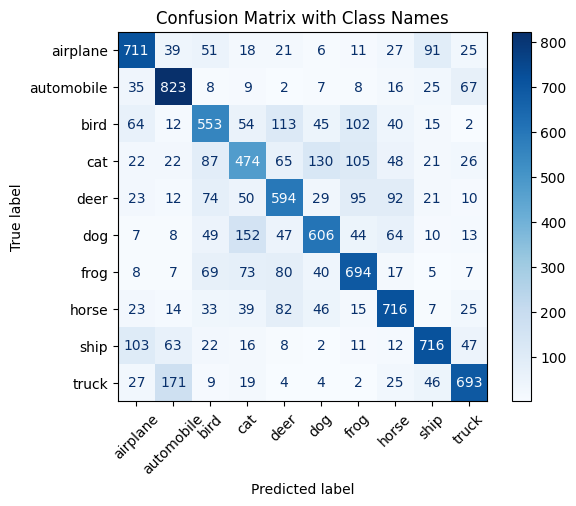

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Generate classification report and confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)  # Adjust cmap and rotation if needed
plt.title("Confusion Matrix with Class Names")
plt.show()

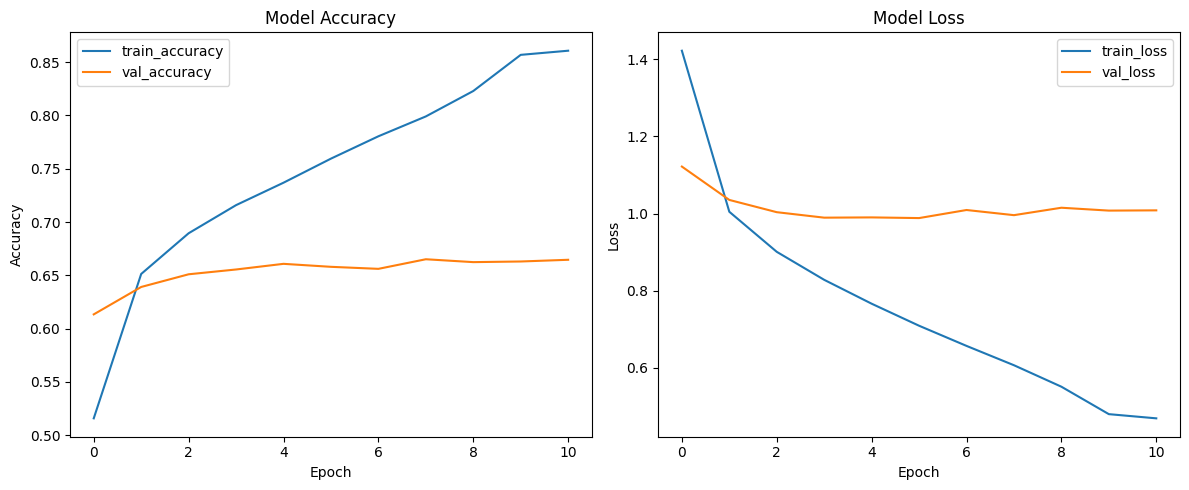

In [12]:
# Create a single figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='train_accuracy')
axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Model Accuracy')

# Loss plot
axes[1].plot(history.history['loss'], label='train_loss')
axes[1].plot(history.history['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('Model Loss')

# Display the plots
plt.tight_layout()
plt.show()

In [13]:
# Initialize InceptionV3 with pre-trained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 50 layers for fine-tuning
for layer in base_model.layers[-500:]:
    layer.trainable = True

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
])

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# Train the model without data augmentation, with early stopping and learning rate reduction callbacks
history = model.fit(
    x_train, y_train,
    batch_size=1024,               # Training batch size
    epochs=50,                   # Set a high epoch count; early stopping may halt it early
    validation_data=(x_test, y_test),
    validation_batch_size=1024,    # Set a custom validation batch size
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.2824 - loss: 2.0336 - val_accuracy: 0.4452 - val_loss: 1.5757 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 567ms/step - accuracy: 0.7767 - loss: 0.6623 - val_accuracy: 0.6441 - val_loss: 1.0279 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 600ms/step - accuracy: 0.9159 - loss: 0.2753 - val_accuracy: 0.7400 - val_loss: 0.7630 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 583ms/step - accuracy: 0.9771 - loss: 0.0973 - val_accuracy: 0.7974 - val_loss: 0.6435 - learning_rate: 1.0000e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 581ms/step - accuracy: 0.9933 - loss: 0.0339 - val_accuracy: 0.8081 - val_loss: 0.6856 - learning_rate: 1.0000e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 604ms/step - accuracy: 0.9973 - loss: 0.0144 - val_accuracy: 0.8165 - val_loss: 0.7271 - learning_rate: 1.0000e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 586ms/step - accur

In [15]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8023 - loss: 0.6311
Test accuracy: 79.74%


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.93      0.80      1000
  automobile       0.86      0.94      0.90      1000
        bird       0.68      0.78      0.73      1000
         cat       0.70      0.61      0.65      1000
        deer       0.80      0.67      0.73      1000
         dog       0.77      0.70      0.73      1000
        frog       0.86      0.84      0.85      1000
       horse       0.83      0.84      0.84      1000
        ship       0.94      0.79      0.86      1000
       truck       0.89      0.87      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



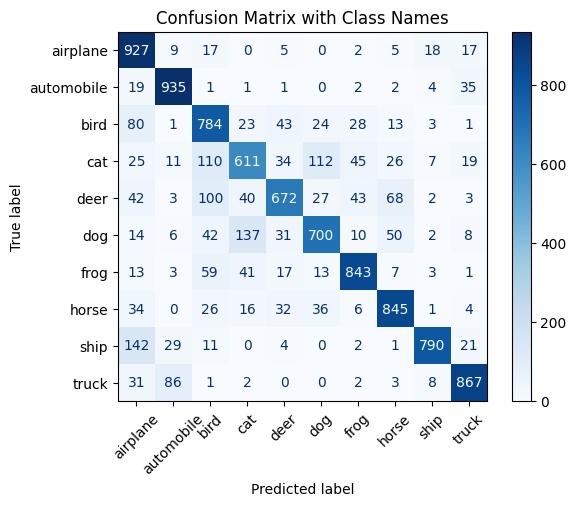

In [17]:
# Generate classification report and confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)  # Adjust cmap and rotation if needed
plt.title("Confusion Matrix with Class Names")
plt.show()

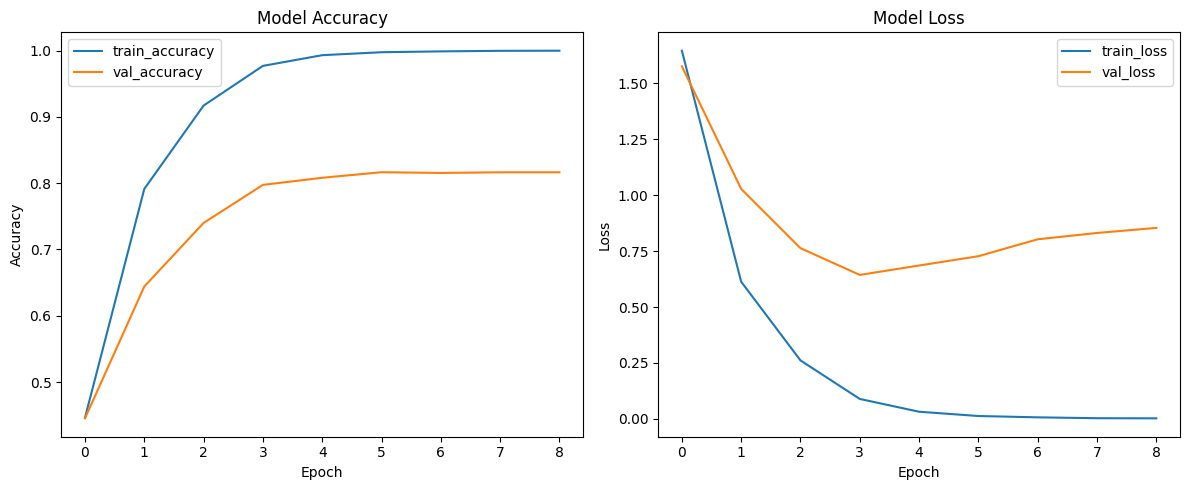

In [18]:
# Create a single figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='train_accuracy')
axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Model Accuracy')

# Loss plot
axes[1].plot(history.history['loss'], label='train_loss')
axes[1].plot(history.history['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('Model Loss')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()